In [5]:
import numpy as np
import torch
import torch.nn as nn

from sklearn.model_selection import train_test_split,cross_validate
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, accuracy_score, average_precision_score

import seaborn as sns
import matplotlib.pyplot as plt
import xgboost

from scipy import interp


def predict_one_shower(shower, graph_embedder, edge_classifier):
    embeddings = graph_embedder(shower)
    edge_labels_true = (shower.y[shower.edge_index[0]] == shower.y[shower.edge_index[1]]).view(-1)
    edge_data = torch.cat([
        embeddings[shower.edge_index[0]],
        embeddings[shower.edge_index[1]]
    ], dim=1)
    edge_labels_predicted = edge_classifier(edge_data).view(-1)

    return edge_labels_true, edge_labels_predicted

In [7]:
sns.set(context='paper', style="whitegrid", font_scale=3, font = 'serif')
linewidth = 3

In [27]:
y_true, y_pred = np.load('../data/y_test.npy'), np.load('../data/y_pred.npy')

In [28]:
y_true_2, y_pred_2 = np.load('../data/y_test_2.npy'), np.load('../data/y_pred_2.npy')

In [29]:
y_true_3, y_pred_3 = np.load('../data/y_test_3.npy'), np.load('../data/y_pred_3.npy')

In [31]:
def tolerant_mean(arrs):
    lens = [len(i) for i in arrs]
    arr = np.ma.empty((np.max(lens),len(arrs)))
    arr.mask = True
    for idx, l in enumerate(arrs):
        arr[:len(l),idx] = l
    return arr.mean(axis = -1), arr.std(axis=-1)


In [32]:
def plot_aucs(Y_true_list, Y_pred_list):

    fig, axs = plt.subplots(nrows=1, ncols=2, sharex=False, figsize=(25, 9), dpi=100)

    ax = axs[0]
    ax.plot([0, 1], [0, 1], linestyle='--', color = 'firebrick', rasterized=True)
    # plot the roc curve for the model
    
    tprs = []
    aucs = []
    base_fpr = np.linspace(0, 1, 101)
    
    for y_true, y_pred  in zip(Y_true_list, Y_pred_list):
        fpr, tpr, _ = roc_curve(y_true, y_pred)

        ax.plot(fpr, tpr, 'steelblue', alpha=0.10)
        tpr = np.interp(base_fpr, fpr, tpr)
        tpr[0] = 0.0
        tprs.append(tpr)
        aucs.append(np.trapz(tpr, base_fpr))

    tprs = np.array(tprs)
    mean_tprs = tprs.mean(axis=0)
    std = tprs.std(axis=0)
    auc = np.mean(aucs)

    tprs_upper = np.minimum(mean_tprs + std, 1)
    tprs_lower = mean_tprs - std

    ax.plot(base_fpr, mean_tprs, 'steelblue', marker='.', rasterized=True, label = "AUC = "+str(np.round(auc,3)))
    ax.fill_between(base_fpr, tprs_lower, tprs_upper, color='steelblue', alpha=0.3)
    ax.set_title('ROC curve \n')
    ax.set_xlabel('FPR (Background efficiency)')
    ax.set_ylabel('TPR (Signal efficiency)')
    ax.legend()
    print(auc)

    ax = axs[1]
    precisions = []
    average_precisions = []
    
    
    for y_true, y_pred  in zip(Y_true_list, Y_pred_list):
        precision, recall, _ = precision_recall_curve(y_true, y_pred)

        ax.plot(recall, precision, 'steelblue', alpha=0.10)
        precisions.append(precision)
        average_precisions.append(average_precision_score(y_true, y_pred))

    mean_precisions, std =  tolerant_mean(precisions)
    average_precision = np.mean(average_precisions)
    
    base_recall = np.linspace(1, 0, len(mean_precisions))

    precisions_upper = np.minimum(mean_precisions + std, 1)
    precisions_lower = mean_precisions - std

    ax.plot([0, 1], [0.5, 0.5], linestyle='--', color = 'firebrick', rasterized=True)
    ax.plot(base_recall, mean_precisions, 'steelblue', marker='.', rasterized=True, 
            label = "AP = "+str(np.round(average_precision,3)))
    ax.fill_between(base_recall, precisions_lower, precisions_upper, color='steelblue', alpha=0.3)
    
    print(average_precision)
    ax.set_title('Precision-Recall Curve \n')
    ax.set_xlabel('Recall (efficiency)')
    ax.set_ylabel('\n \n  Precision (Purity)')
    ax.legend(loc = 'lower right')

    #fig.suptitle('Test set metrics')
    plt.savefig("Classificator_metrics.pdf", bbox_inches='tight')
    return fig

0.835923263266609
0.952472736458868


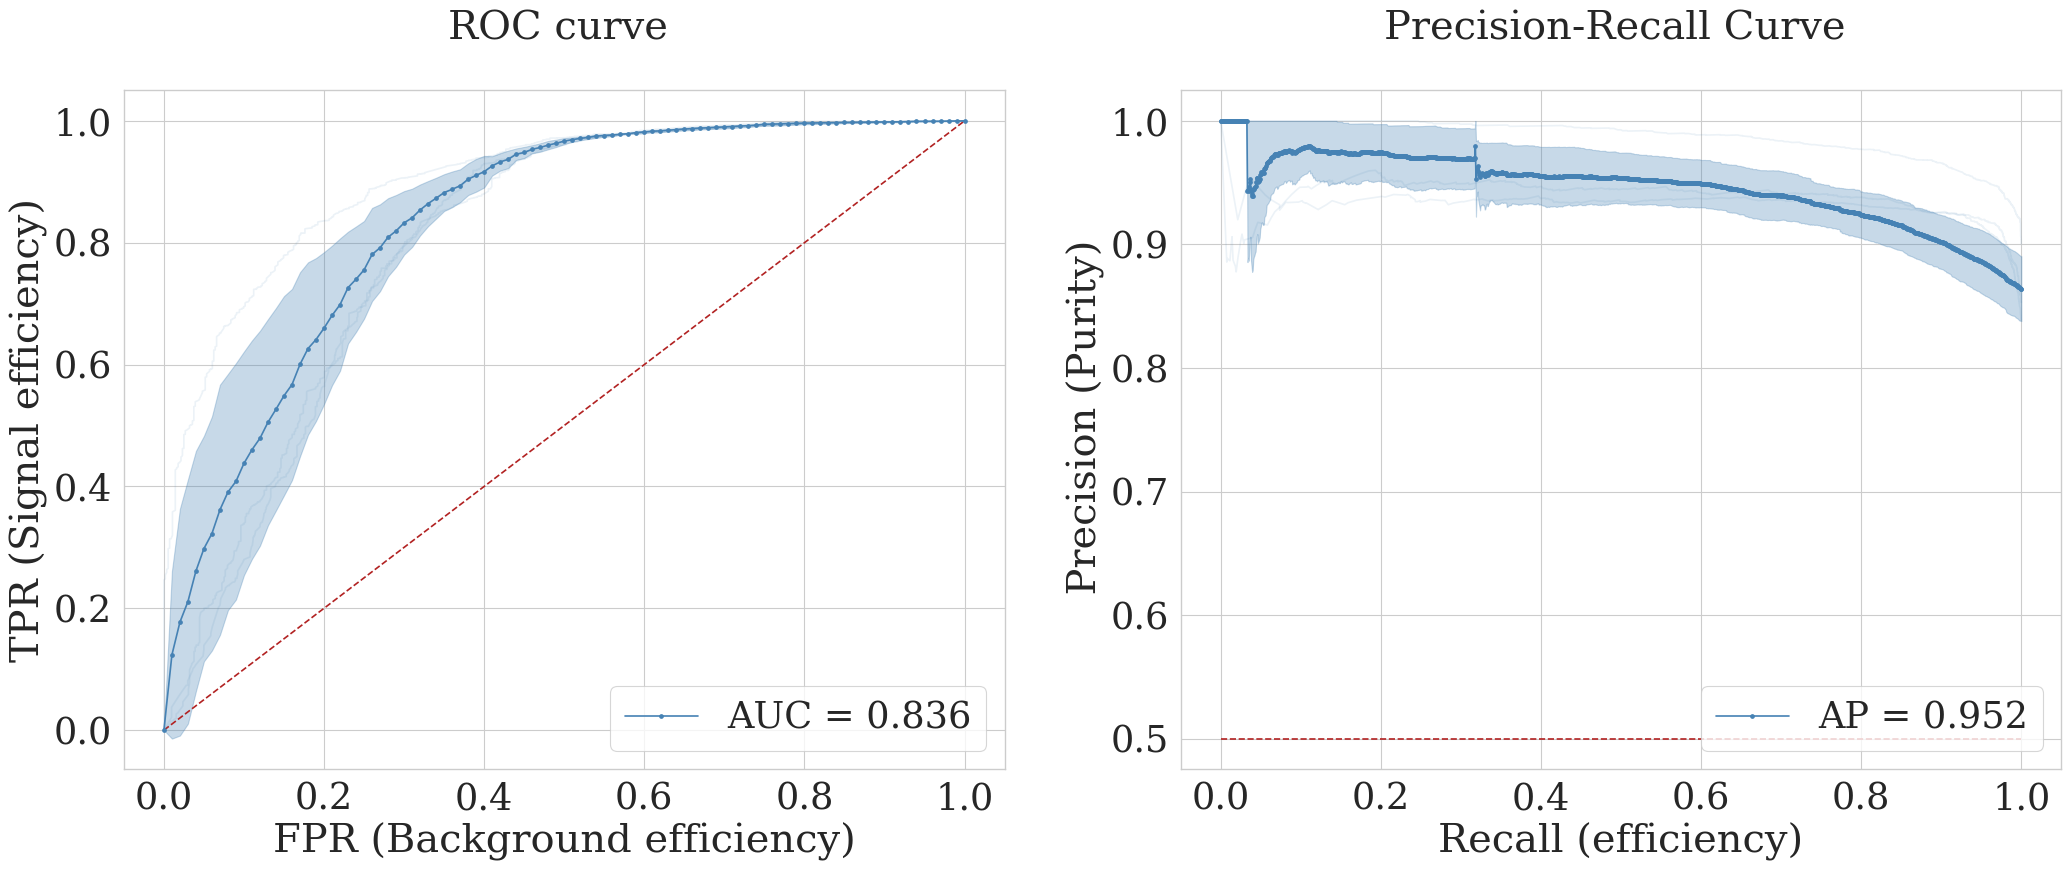

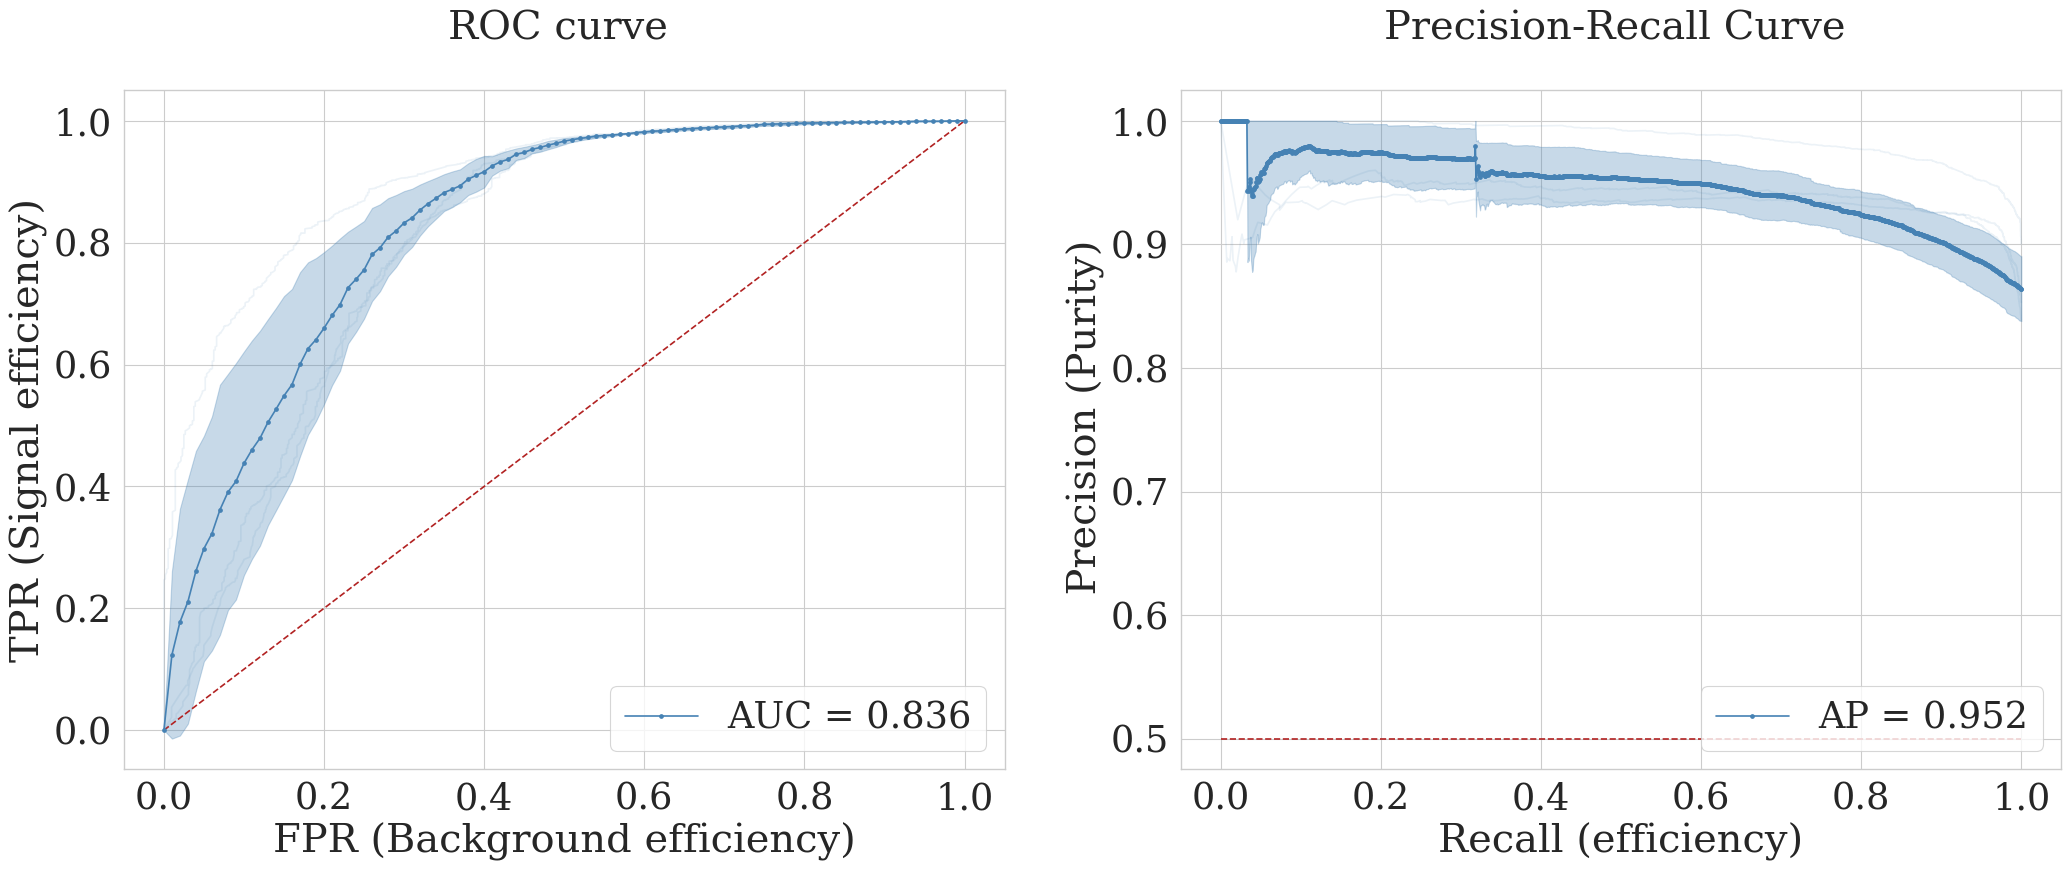

In [33]:
plot_aucs([y_true, y_true_2, y_true_3], [y_pred, y_pred_2, y_pred_3])